Bibliography:

[1] [@bank2021autoencoders]: Dor Bank, Noam Koenigstein, and Raja Giryes. "Autoencoders." arXiv preprint arXiv:2003.05991 (2021).


# Visualising data with Autoencoders and Variational Autoencoders

### 1. FMNIST preparation

First download dataset from github.
https://github.com/zalandoresearch/fashion-mnist

or get from zip

I recommend to clone their repository (Best to do that outside of your local repo)
It will also provide us with loading functions

git clone https://github.com/zalandoresearch/fashion-mnist.git   

If cloned images/labels should be in fashion-mnist\data\fashion


In [13]:
import sys
#set your path to the fashion-mnist/utils folder
sys.path.append(os.getcwd() + '/fashion-mnist/utils')

import mnist_reader

In [14]:
X_train, y_train = mnist_reader.load_mnist('./fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('./fashion-mnist/data/fashion', kind='t10k')

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


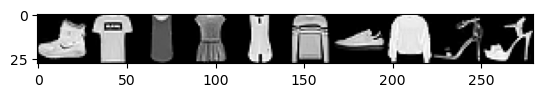

In [16]:
#show first 10 images 
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.hstack(X_train[:10].reshape(10,28,28)), cmap='gray')

In [17]:
X_train.min(), X_train.max()

(0, 255)

Lets normalize data to 0,1

In [18]:
import torch

X_train = X_train / X_train.max()
X_test = X_test / X_test.max()
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### 2. Autoencoders 
Network trained to reduce number of dimmensions in data while perserving minimal reconstruction loss of information.
It's composed of 2 layers where one compresses and second one decompresses input data. While both compresser and decompresser are trained silmutainously they minimise loss of information after that 2 procedures. 

#### Applications of Autoencoders


Dimensionality Reduction (reducing number of dimmensions of input data)

- It can be used as lossy Image/Audio Compression 
- even as substitute of methods like TSNE to compress numerical data into 2/3 dimmensions to plot them.

Image Denoising - AE can be trained to recover data from noised verision (ex. Variational AutoEncoder)

Variational Autoencoder about which will be next section can also be used for generative modeling.

    




   - Model explanation (encoding - decoding)


![
    Autoencoder model architecture from [1] [@bank2021autoencoders]
](aemodel.png) 
<p> Autoencoder model architecture from [1] [@bank2021autoencoders]</p>

Autoencoders are models that are composed of 2 sections:<b> Encoding layer, Decoding layer.</b> Both are simple blocks composed of Dense Layers and Activation functions.

<h3>Encoder</h3>

    `INPUT_SIZE` -> ...  -> `LATENT SPACE SIZE`
    Input -- `ENCODER` --> `Reduced representation`

<h3>Decoder</h3>

    `LATENT SPACE SIZE` -> ... -> `INPUT_SIZE` 
    `Reduced representation`  -- `DECODER` --> Output

<h3>Combined</h3>

where if we want it to encode, `LATENT SPACE` should be smaller than `INPUT_SIZE`. On its own, if we pass data through a layer that gives a smaller output, we will receive less information. That reduced form:

    Input -- `ENCODER` --> `Reduced representation`  -- `DECODER` --> Output 

Reduced output goes to the second block, which is `DECODER`. The decoder does the inverse mechanism. It will be a dense layers block that should, take `LATENT SPACE SIZE` shape data and transform it back to `INPUT_SIZE` data.


<h2>INPUT SIZE</h2>

In [19]:
#show size of input data
print(X_train.shape)

torch.Size([60000, 784])


`INPUT SIZE` is 784

As `LATENT SPACE SIZE` we need something smaller and for this to be visualisable lets keep it square: for example 20*20 = 400.


So in summary:

- ENCODER:
``` python
    self.encoder = nn.Sequential(
        nn.Flatten(), # splaszczanie (opcjonalne)
        nn.Linear(input_size,input_size//2), # 1 warstwa gesta
        nn.ReLU(), #aktywacja
        nn.Linear(input_size//2,latent_space_size), #2 warstwa gesta
    )
```
- DECODER:
``` python
    self.decoder = nn.Sequential(
        nn.Linear(latent_space_size, input_size//2), # 1 gesta
        nn.ReLU(), #aktywacja
        nn.Linear(input_size//2, input_size), #gesta do przejscia z powrotem do rozmiaru wejsciowego
        nn.Sigmoid() #sigmoida do utrzymania wartosci na 0,1
    )
```

In [20]:
BATCH_SIZE = 64
INPUT_SIZE = 28*28
LATENT_SPACE_SIZE = 20*20
LATENT_SPACE_SHAPE = (20,20)
LATENT_SPACE_SIDE = 20

In [21]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, latent_space_size = LATENT_SPACE_SIZE):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2,latent_space_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, input_size//2),
            nn.ReLU(),
            nn.Linear(input_size//2, input_size),
            nn.Sigmoid()
        )
        self.latent_space_shape = latent_space_size
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def loss_calculation(self, recon_x, x, loss_func):
        loss = loss_func(recon_x, x)
        return loss

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

Having a way to compress and decompress data now it's time to direct this mechanism into better results.
As the cost function we will calculate difference between input_image and output after encoding and decoding.
Our goal is to train encoder and decoding layer is mostly used for training so that we are able to compare output with input.

A -> encode -> B -> decode -> C

    cost = abs( A - C ) 
    
describes the loss of information which we want to minimalize

Knowing what we want from our cost function we will use MSE: 
mean square error which will look like this:

    cost = mean( (A - C)^2 )

In [22]:
def ae_cost_function(
    model,  #ignore it
    recon_x,#reconstructed data
    x       #input data
    ):
    #TODO return MSE reconstruction error using torch.nn.MSELoss
    return torch.nn.MSELoss()(recon_x, x)

Before training let's also prepare function that will allow us to preview image in reduced representation, to validate empirically our progress.

In [23]:
import torch
import math

def preview_samples( samples, image_shape=(28,28) ):
    plt.imshow(np.hstack(samples.reshape(-1 ,image_shape[0], image_shape[1])))
    plt.show()

def plot_3_sample_rows(input, latent, output):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original samples")
    plt.imshow(input)
    
    plt.subplot(1, 3, 2)
    plt.title("Compressed samples")
    plt.imshow(latent)

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed samples")
    plt.imshow(output)
    plt.show()

def plot_compression_process(model, input_data, input_output_shape, latent_size ):
    samples = input_data
    side = int(math.sqrt(latent_size))
    
    latent_shape = (side, latent_size//side)

    input_image = np.hstack(samples.reshape(-1 ,input_output_shape[0], input_output_shape[1]))
    
    compressed_samples = model.encode(samples).detach().numpy()
    latent_image = np.hstack(compressed_samples.reshape(-1 , *latent_shape))

    reconstructed_samples = model.decode(torch.tensor(compressed_samples)).detach().numpy()
    decompressed_image = np.hstack(reconstructed_samples.reshape(-1 ,input_output_shape[0], input_output_shape[1]))
    plot_3_sample_rows(input_image, latent_image, decompressed_image)

In [31]:
def train_ae_variations(model,
                        loss_function,
                        batch_size= BATCH_SIZE, 
                        epochs=5, 
                        learning_rate=1e-4, 
                        plot_2d_latent = False, 
                        plot_decompressed = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    data = torch.utils.data.DataLoader(X_train.view(-1, INPUT_SIZE), batch_size=batch_size, shuffle=True)
    
    for i in range(epochs):
        batch_loss = 0
        for batch in data:
            optimizer.zero_grad()
            recon_batch = model.to(device)(batch.to(device))
            loss = loss_function(model, recon_batch, batch.to(device))
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        loss_history.append(batch_loss/len(data))
        print(f'Epoch {i} Loss: {loss.item()}')
        if(plot_2d_latent):
            compressed_samples = model.encode(X_test.view(-1, INPUT_SIZE).to(device)).cpu().detach().numpy()
            plt.scatter(compressed_samples[:,0], compressed_samples[:,1], c=y_test, cmap='tab10')
            plt.colorbar()
            plt.show()
            
        if(plot_decompressed):
            sample_data = X_test[:10].view(-1, INPUT_SIZE).to(device)
            plot_compression_process(model.cpu(), sample_data.cpu(), (28,28), model.latent_space_shape)
            
    return loss_history

In [25]:
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

Epoch 0 Loss: 0.023856544867157936


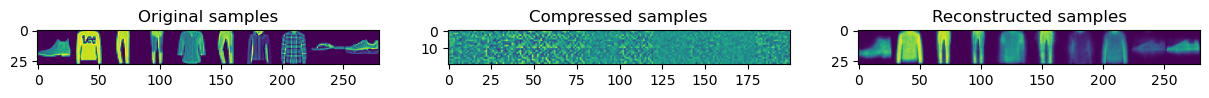

Epoch 1 Loss: 0.018623147159814835


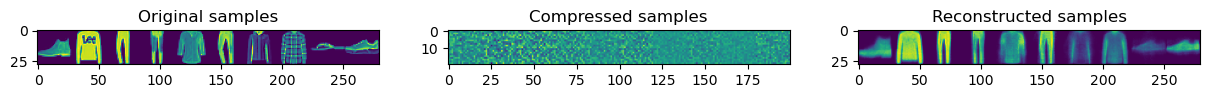

Epoch 2 Loss: 0.017406022176146507


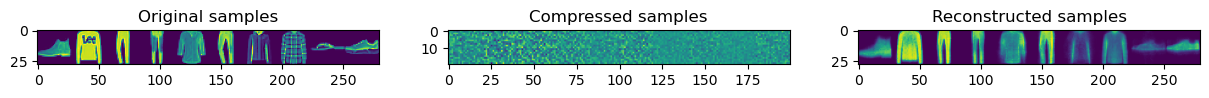

Epoch 3 Loss: 0.014775313436985016


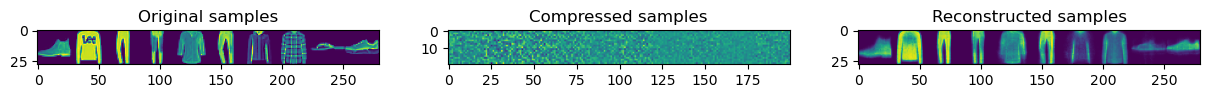

Epoch 4 Loss: 0.012600935995578766


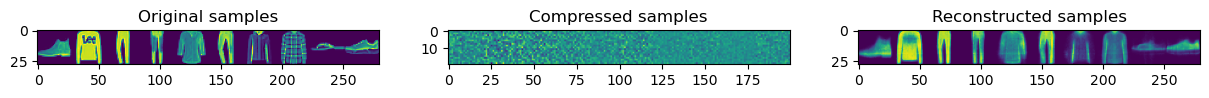

In [26]:
ae = Autoencoder()
loss_history = train_ae_variations(
    ae,
    ae_cost_function,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    plot_decompressed=True
)

<h2> Encoding to 2 dimensions and plotting.</h2>

   We can use it to visualize data as point in embedded space. Each image will be converted into 2 dimmensional point (2 values).

In [27]:
def plot_2d_representation(x, y):
    plt.scatter( 
                    x[:,0],
                    x[:,1], 
                    c=y,
                    cmap='tab10'
                )
    plt.colorbar()
    plt.show()

Epoch 0 Loss: 0.036608461290597916


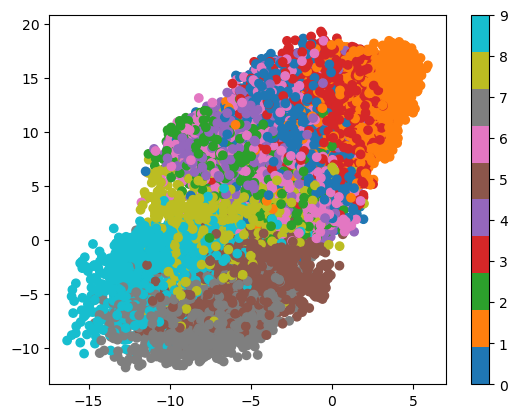

Epoch 1 Loss: 0.04189083352684975


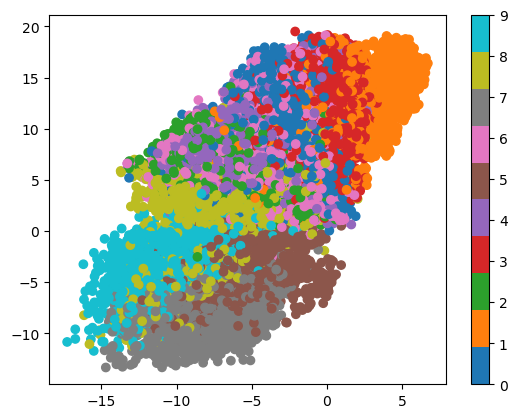

Epoch 2 Loss: 0.031145485118031502


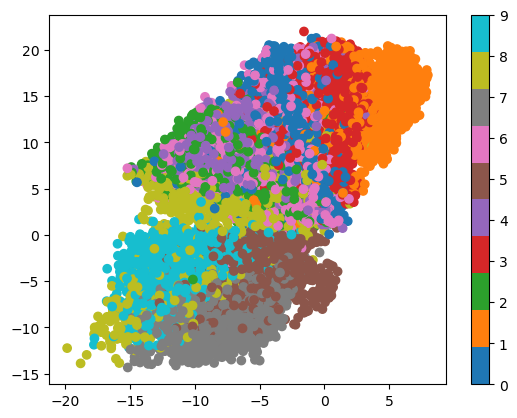

Epoch 3 Loss: 0.031088225543498993


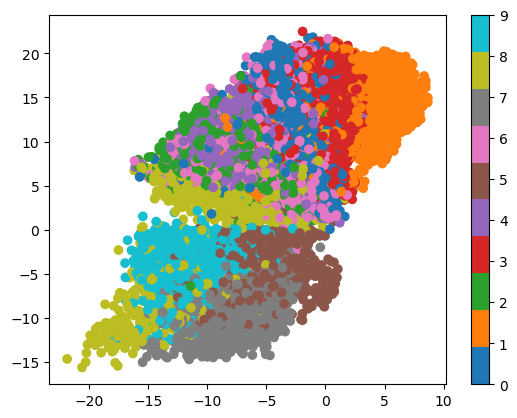

Epoch 4 Loss: 0.02694084867835045


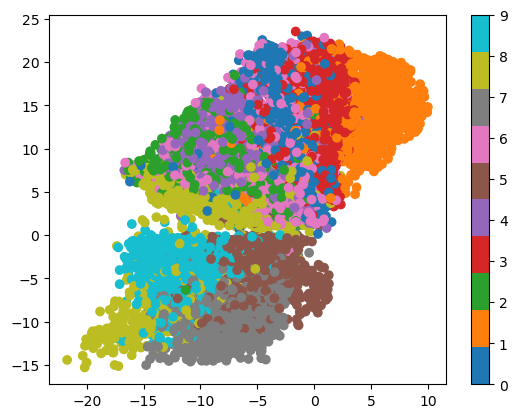

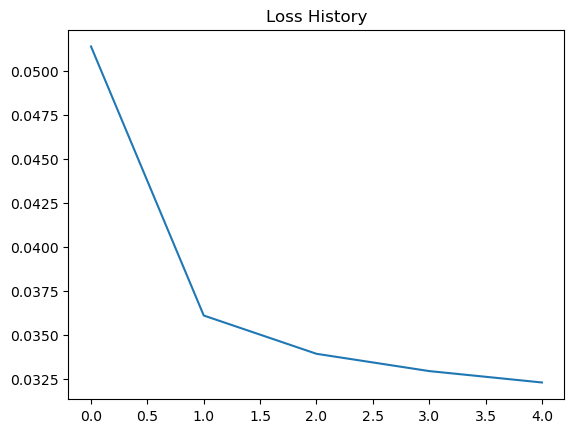

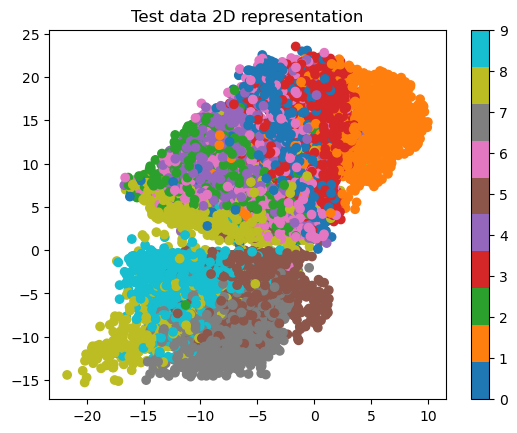

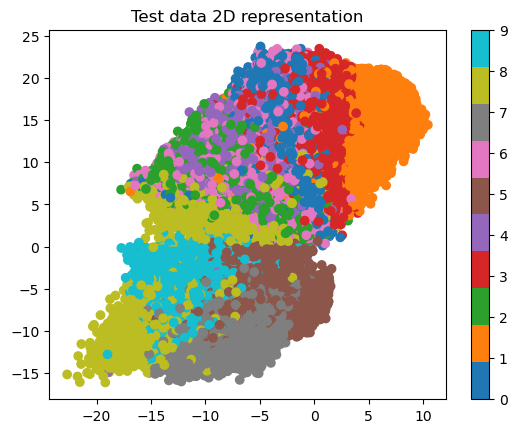

In [34]:
ae = Autoencoder(latent_space_size=2)
loss_history = train_ae_variations(ae, ae_cost_function, epochs=5, plot_2d_latent=True)
plt.plot(loss_history)
plt.title("Loss History")
plt.show()    

test_2d_representation = ae.encode(X_test.view(-1, INPUT_SIZE).to(device)).detach().cpu().numpy()
plt.title("Test data 2D representation")
plot_2d_representation(test_2d_representation, y_test )

test_2d_representation = ae.encode(X_train.view(-1, INPUT_SIZE).to(device)).detach().cpu().numpy()
plt.title("Test data 2D representation")
plot_2d_representation(test_2d_representation, y_train)


### 3. Variational Autoencoder 
   - Model explanation 
   - Mathematical formulas for noise injection 
   - Encoding to 2 dimensions and plotting
   - Probkowanie fantazji sieci


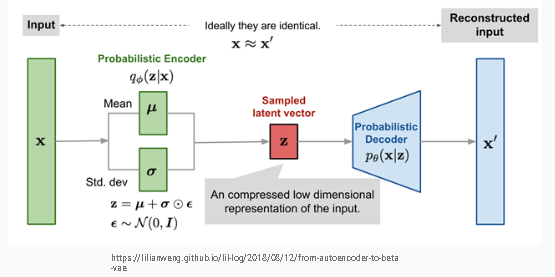

vae wyciaga z danych srednia i odchylenie standardowe za pomoca warstw gestych i sklada je razem z rozkladem  normalnym w zredukowana reprezentacje Z.
Dekoder dziala analogicznie do zwyklego AE.

Obliczanie funkcji kosztu jest rowniez obarczone dodatkowymi obliczeniami

In [35]:
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEEncoder, self).__init__()

        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_mean  = nn.Linear(hidden_dim, latent_dim) #variational part
        self.linear_var   = nn.Linear (hidden_dim, latent_dim) #variational part
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.linear_1(x))
        h_       = self.LeakyReLU(self.linear_2(h_))
        mean     = self.linear_mean(h_)
        log_var  = self.linear_var(h_)                     # encoder produces mean and log of variance 
                                                           # (i.e., parameters of simple tractable normal distribution "q"
        return mean, log_var
    
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAEDecoder, self).__init__()
        self.linear_1 = nn.Linear(latent_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.linear_1(x))
        h     = self.LeakyReLU(self.linear_2(h))
        
        x_hat = torch.sigmoid(self.hidden_3(h))
        return x_hat
        
class VAEModel(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAEModel, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)     # sampling epsilon        
        z = mean + var*epsilon         # reparameterization trick
        return z
        
    def encode(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

Na funkcje kosztu sklada sie juz nie tylko samo MSE roznicy pomiedzy danymi wejsciowymi a zrekonstruowanym wynikiem, ale dodajemy tez KLD.

In [36]:
def vae_cost_function(x, x_hat, mean, log_var):
    reproduction_loss = None

    #TODO: MSE LOSS for reproduction loss part with reduction='sum' argument
    reproduction_loss = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [37]:
from torch.optim import Adam
encoder = VAEEncoder(input_dim=INPUT_SIZE, hidden_dim=INPUT_SIZE//2, latent_dim=2)
decoder = VAEDecoder(latent_dim=2, hidden_dim = INPUT_SIZE//2, output_dim = INPUT_SIZE)

vae = VAEModel(Encoder=encoder, Decoder=decoder)
optimizer = Adam(vae.parameters(), lr = 0.001)

Start training VAE...
	Epoch 1 complete! 	Average Loss:  34.431120439378944


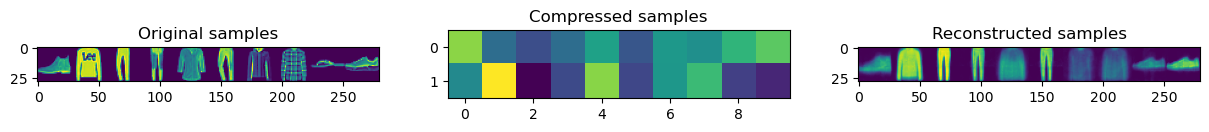

	Epoch 2 complete! 	Average Loss:  30.271622993290297


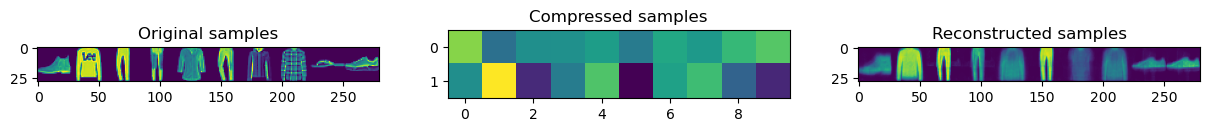

	Epoch 3 complete! 	Average Loss:  29.2561624258566


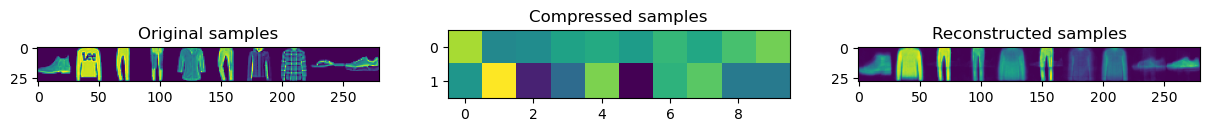

	Epoch 4 complete! 	Average Loss:  28.774561114402722


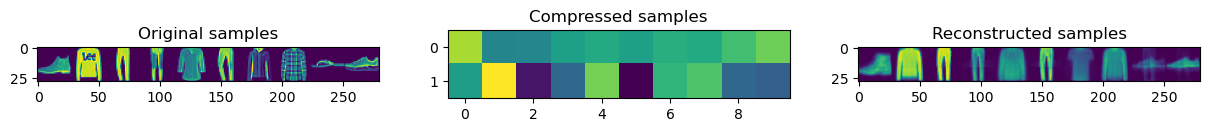

	Epoch 5 complete! 	Average Loss:  28.45158069525192


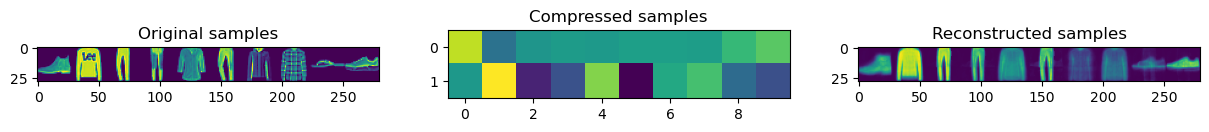

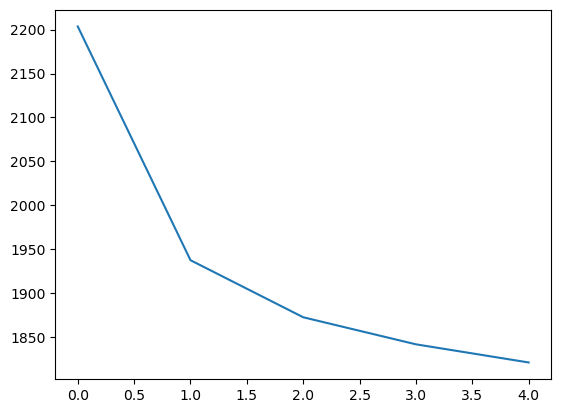

Finish!!


In [38]:
def train_vae(model, epochs, lr, batch_size):
    print("Start training VAE...")
    model.train()            
    loss_history = []
    batched_data = torch.utils.data.DataLoader(X_train.view(-1, INPUT_SIZE), batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        overall_loss = 0
        i=0
        
        for batch in batched_data:
            i+=1
            x = batch

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = vae_cost_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        loss_history.append(overall_loss/len(batched_data))
        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*batch_size))
        
        sample_data = X_test[:10].view(-1, INPUT_SIZE)
        input_image = np.hstack(sample_data.detach().numpy().reshape(-1 ,28, 28))
        compressed_samples = model.encode(sample_data).detach().numpy()
        compressed_image = np.hstack(compressed_samples.reshape(-1 ,2, 1))
        reconstructed_samples = model(sample_data)[0].detach().numpy()
        plot_3_sample_rows(input_image, compressed_image, np.hstack(reconstructed_samples.reshape(-1 ,28, 28)))

    #plot loss
    plt.plot(loss_history)
    plt.show()
    print("Finish!!")

train_vae(vae, epochs=5, lr=0.001, batch_size=64)

<h2>PLOT 2d vae representation</h2 >

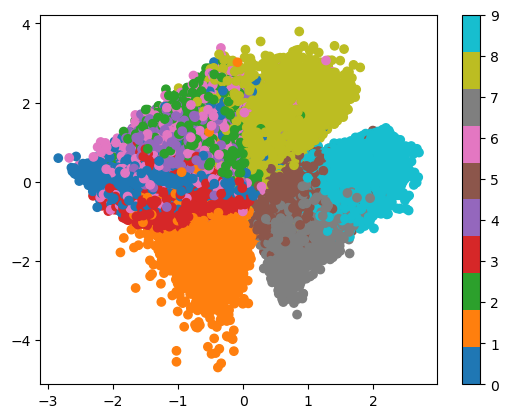

In [39]:
input = X_train.view(-1,INPUT_SIZE)
plot_2d_representation(vae.encode(input).detach().numpy(), y_train)

<h2>CALCULATING METRICS FOR COMPARISON FOR MODELS</h2>

In [40]:
ae.eval()
ae.to(device)
X_test = X_test.to(device)
reconstructed = ae(X_test.view(-1, INPUT_SIZE))
print(reconstructed.shape)

print(ae_cost_function(ae, reconstructed, X_test.view(-1, INPUT_SIZE)))

torch.Size([10000, 784])
tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)


In [41]:
vae.eval()
vae.to(device)
reconstructed, _, _  = vae(X_test.to(device).view(-1, INPUT_SIZE))
print(reconstructed.shape)
print(ae_cost_function(vae, reconstructed , X_test.view(-1, INPUT_SIZE)))

torch.Size([10000, 784])
tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)


<h2>Generate based on noise</h2>
VAE is also generative model. Because of it's noise injection you can generate random noise and pass it through decoder. it is not that extra with 2d latent space.

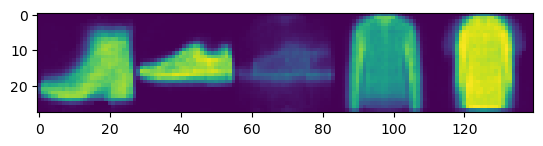

In [42]:
n_to_generate = 5
random_latent = torch.randn(n_to_generate, 2)
generated = vae.Decoder(random_latent.to(device))
plt.imshow( np.hstack(generated.cpu().detach().numpy().reshape(-1 ,28, 28)) )